# WELCOME EVERYONE IN MY NOTEBOOK

# Install Dependencies

In [1]:
%pip install --quiet /kaggle/input/timm_3d_deps/other/initial/9/pydicom/pydicom/pydicom-2.4.4-py3-none-any.whl
%pip install timm_3d --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/9/timm_3d/
%pip install torchio --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/9/torchio/
%pip install itk --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/9/itk/itk
%pip install skorch --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/9/skorch/skorch
%pip install spacecutter --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/9/spacecutter/
%pip install open3d --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/9/open3d

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have py

# Import library

In [2]:
import pandas as pd
import os
import open3d as o3d
from pydicom import dcmread
import math
import numpy as np
import cv2
import copy
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchio as tio
import torch.nn as nn
import pydicom
import matplotlib.pyplot as plt
import glob 
import torch
import torch.nn as nn
import timm_3d
from spacecutter import *
from spacecutter.losses import *
from spacecutter.models import *
from spacecutter.callbacks import *
import glob
import os
import torch
from torch.cuda.amp import autocast
import time


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Data Retrieval

In [3]:
data_path = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/"
def retrieve_test_data(data_path):
    test_df = pd.read_csv(data_path + 'test_series_descriptions.csv')
    print("Test data retrieved successfully.")
    return test_df

retrieve_test_data(data_path)

Test data retrieved successfully.


,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


# Retrieve Image Paths

In [4]:
def retrieve_image_paths(base_path, study_id, series_id):
    series_dir = os.path.join(base_path, str(study_id), str(series_id))
    images = os.listdir(series_dir)
    image_paths = [os.path.join(series_dir, img) for img in images]
    print(f"Retrieved image paths for study_id: {study_id}, series_id: {series_id}.")
    return image_paths

# Read Study as PCD

In [5]:
# Step 3: Read Study as Point Cloud Data
def read_study_as_pcd(dir_path, series_types_dict=None, downsampling_factor=1, img_size=(256, 256)):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        x_orig, y_orig = dicom_slice.pixel_array.shape
        img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
        x, y, z = np.where(img)

        downsampling_factor_iter = max(downsampling_factor, int(math.ceil(len(x) / 6e6)))

        index_voxel = np.vstack((x, y, z))[:, ::downsampling_factor_iter]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor_iter], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness

        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY

        for z in range(int(dZ)):
            pos = list(dicom_slice.ImagePositionPatient)
            if series_desc == "T2":
                pos[-1] += z
            else:
                pos[0] += z
            S = np.array(pos + [1])

            transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
            transform_matrix = transform_matrix @ np.matrix(
                [[0, y_orig / img_size[1], 0, 0],
                 [x_orig / img_size[0], 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )

            pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

    return pcd_overall

# Read Study as Voxel Grid

In [6]:
def read_study_as_voxel_grid(dir_path, series_type_dict=None, downsampling_factor=1, img_size=(256, 256)):
    pcd_overall = read_study_as_pcd(dir_path,
                                    series_types_dict=series_type_dict,
                                    downsampling_factor=downsampling_factor,
                                    img_size=img_size)
    box = pcd_overall.get_axis_aligned_bounding_box()

    max_b = np.array(box.get_max_bound())
    min_b = np.array(box.get_min_bound())

    pts = (np.array(pcd_overall.points) - (min_b)) * (
                (img_size[0] - 1, img_size[0] - 1, img_size[0] - 1) / (max_b - min_b))
    coords = np.round(pts).astype(np.int32)
    vals = np.array(pcd_overall.colors, dtype=np.float16)

    grid = np.zeros((3, img_size[0], img_size[0], img_size[0]), dtype=np.float16)
    indices = coords[:, 0], coords[:, 1], coords[:, 2]

    np.maximum.at(grid[0], indices, vals[:, 0])
    np.maximum.at(grid[1], indices, vals[:, 1])
    np.maximum.at(grid[2], indices, vals[:, 2])

    print("Study read as voxel grid successfully.")
    return grid


# Create Patient Level Testset

In [7]:
CONDITIONS = {
    "Sagittal T2/STIR": ["Spinal Canal Stenosis"],
    "Axial T2": ["Left Subarticular Stenosis", "Right Subarticular Stenosis"],
    "Sagittal T1": ["Left Neural Foraminal Narrowing", "Right Neural Foraminal Narrowing"],
}

In [8]:
class PatientLevelTestset(Dataset):
    def __init__(self,
                 base_path: str,
                 dataframe: pd.DataFrame,
                 transform_3d=None):
        self.base_path = base_path

        self.dataframe = (dataframe[['study_id', "series_id", "series_description"]]
                          .drop_duplicates())

        self.subjects = self.dataframe[['study_id']].drop_duplicates().reset_index(drop=True)
        self.series_descs = {e[0]: e[1] for e in self.dataframe[["series_id", "series_description"]].drop_duplicates().values}

        self.transform_3d = transform_3d

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, index):
        curr = self.subjects.iloc[index]
        study_path = os.path.join(self.base_path, str(curr["study_id"]))

        study_images = read_study_as_voxel_grid(study_path, self.series_descs)

        if self.transform_3d is not None:
            study_images = self.transform_3d(torch.FloatTensor(study_images))  # .data
            return study_images.to(torch.half), str(curr["study_id"])

        return torch.HalfTensor(study_images), str(curr["study_id"])

# Create Data Loader

In [9]:
transform_3d = tio.Compose([
    tio.RescaleIntensity([0, 1]),
])

In [10]:
def create_subject_level_testset_and_loader(df: pd.DataFrame,
                                             transform_3d,
                                             base_path: str,
                                             batch_size=1,
                                             num_workers=0):
    testset = PatientLevelTestset(base_path, df, transform_3d=transform_3d)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    print("Subject level testset and data loader created successfully.")
    return testset, test_loader

In [11]:
data = retrieve_test_data(data_path)
dataset, dataloader = create_subject_level_testset_and_loader(data, transform_3d, os.path.join(data_path, "test_images"))

Test data retrieved successfully.
Subject level testset and data loader created successfully.


# Visualize Grid

Study read as voxel grid successfully.


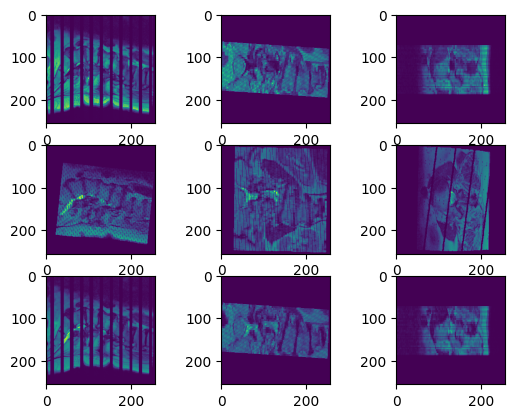

Visualization completed.


In [12]:
grid = dataset[0][0]

fig, axs = plt.subplots(3, 3)

axs[0, 0].imshow(grid[0, 128])
axs[1, 0].imshow(grid[1, 128])
axs[2, 0].imshow(grid[2, 128])

axs[0, 1].imshow(grid[0, :, 128])
axs[1, 1].imshow(grid[1, :, 128])
axs[2, 1].imshow(grid[2, :, 128])

axs[0, 2].imshow(grid[0, :, :, 128])
axs[1, 2].imshow(grid[1, :, :, 128])
axs[2, 2].imshow(grid[2, :, :, 128])

plt.show()
print("Visualization completed.")


In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# Define Model

In [14]:
class CNN_Model_3D_Multihead(nn.Module):
    def __init__(self,
                 backbone="efficientnet_lite0",
                 in_chans=1,
                 out_classes=5,
                 cutpoint_margin=0.15,
                 pretrained=False):
        super(CNN_Model_3D_Multihead, self).__init__()
        self.out_classes = out_classes

        self.encoder = timm_3d.create_model(
            backbone,
            features_only=False,
            drop_rate=0,
            drop_path_rate=0,
            pretrained=pretrained,
            in_chans=in_chans,
            global_pool="max"
        )
        if "efficientnet" in backbone:
            head_in_dim = self.encoder.classifier.in_features
            self.encoder.classifier = nn.Sequential(
                nn.LayerNorm(head_in_dim),
                nn.Dropout(0),
            )

        elif "vit" in backbone:
            self.encoder.head.drop = nn.Dropout(0)
            head_in_dim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(head_in_dim, 1),
                LogisticCumulativeLink(3)
            ) for i in range(out_classes)]
        )

        self.ascension_callback = AscensionCallback(margin=cutpoint_margin)

    def forward(self, x):
        feat = self.encoder(x)
        return torch.swapaxes(torch.stack([head(feat) for head in self.heads]), 0, 1)

    def _ascension_callback(self):
        for head in self.heads:
            self.ascension_callback.clip(head[-1])

In [15]:
model = CNN_Model_3D_Multihead(backbone="maxvit_rmlp_tiny_rw_256", in_chans=3, out_classes=25).to(device)
model.load_state_dict(torch.load("/kaggle/input/rsna-2024/pytorch/vit_voxel_v2/7/maxvit_rmlp_tiny_rw_256_256_v2_fold_3_32.pt"))

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_23/1425751659.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.s

<All keys matched successfully>

In [16]:
CONDITIONS = {
    "Sagittal T2/STIR": ["spinal_canal_stenosis"],
    "Axial T2": ["left_subarticular_stenosis", "right_subarticular_stenosis"],
    "Sagittal T1": ["left_neural_foraminal_narrowing", "right_neural_foraminal_narrowing"],
}

ALL_CONDITIONS = sorted(["spinal_canal_stenosis", "left_subarticular_stenosis", "right_subarticular_stenosis", "left_neural_foraminal_narrowing", "right_neural_foraminal_narrowing"])
LEVELS = ["l1_l2", "l2_l3", "l3_l4", "l4_l5", "l5_s1"]

results_df = pd.DataFrame({"row_id":[], "normal_mild": [], "moderate": [], "severe": []})

ALL_CONDITIONS

['left_neural_foraminal_narrowing',
 'left_subarticular_stenosis',
 'right_neural_foraminal_narrowing',
 'right_subarticular_stenosis',
 'spinal_canal_stenosis']

# Pre-populate results df

In [17]:
study_ids = glob.glob("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/*")
study_ids = [os.path.basename(e) for e in study_ids]

results_df = pd.DataFrame({"row_id":[], "normal_mild": [], "moderate": [], "severe": []})
for study_id in study_ids:
    for condition in ALL_CONDITIONS:
        for level in LEVELS:
            row_id = f"{study_id}_{condition}_{level}"
            results_df = results_df._append({"row_id": row_id, "normal_mild": 1/3, "moderate": 1/3, "severe": 1/3}, ignore_index=True)

In [18]:
dataset.dataframe

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


# Initialize Model and Load Weights

In [19]:
# Step 9: Initialize Model and Load Weights
#model = CNN_Model_3D_Multihead(backbone="maxvit_rmlp_tiny_rw_256", in_chans=3, out_classes=25).to(device)
#model.load_state_dict(torch.load("/kaggle/input/rsna-2024/pytorch/vit_voxel_v2/7/maxvit_rmlp_tiny_rw_256_256_v2_fold_3_32.pt", map_location=device), strict=False)

#model.eval()


# Make Predictions

In [20]:
# Step 11: Make Predictions
start_time = time.time()

with torch.no_grad():
    with autocast(dtype=torch.float16):
        model.eval()

        for images, study_id in dataloader:
            output = model(images.to(device))
            for i, batch_out in enumerate(output):
                batch_out = output.cpu().numpy()[i]
                for index, level in enumerate(batch_out):
                    row_id = f"{study_id[i]}_{ALL_CONDITIONS[index // 5]}_{LEVELS[index % 5]}"
                    results_df.loc[results_df.row_id == row_id,'normal_mild'] = level[0]
                    results_df.loc[results_df.row_id == row_id,'moderate'] = level[1]
                    results_df.loc[results_df.row_id == row_id,'severe'] = level[2]
                
print("--- %s seconds ---" % (time.time() - start_time))


/tmp/ipykernel_23/4018135150.py:5: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Study read as voxel grid successfully.
--- 18.957952737808228 seconds ---


# Prepare Submission File

In [21]:
results_df

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.416031,0.406802,0.177167
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.551157,0.380298,0.068545
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.303012,0.541103,0.155885
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.146881,0.501662,0.351457
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.050625,0.230831,0.718544
5,44036939_left_subarticular_stenosis_l1_l2,0.593061,0.324840,0.082099
6,44036939_left_subarticular_stenosis_l2_l3,0.238710,0.521463,0.239828
7,44036939_left_subarticular_stenosis_l3_l4,0.209273,0.538242,0.252485
8,44036939_left_subarticular_stenosis_l4_l5,0.150982,0.490380,0.358637
9,44036939_left_subarticular_stenosis_l5_s1,0.050674,0.254995,0.694331


In [22]:
results_df.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.
